# SNMF approach: predict part of plant

## Contents
- [1. Imports](#1.-Imports)
- [2. Compute models](#2.-Compute-models)
- [3. Predicting parts of plants](#3.-Predicting-parts-of-plants)
- [4. Results](#4.-Results)


[Back to Chemfin](../Chemfin.ipynb)

### 1. Imports

[Back to contents](#Contents)

In [1]:
%env OMP_NUM_THREADS=4
%env MKL_NUM_THREADS=4

env: OMP_NUM_THREADS=4
env: MKL_NUM_THREADS=4


In [3]:
import sys
sys.path.append('../src/')

from computational_utils import reshape

import numpy as np
import pandas as pd
import copy
import time
import scipy

from sklearn.metrics import accuracy_score

from matrix import estimateMzPolarityFactors
from matrix import MatrixClassifierLCMS

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import dcor


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
rank=25

### 2. Compute models

[Back to contents](#Contents)

In [3]:
data_dirname = '../data/'
model_dirname = '../models/matrix_decomposition/'
model_filename_prefix = 'parts_model_md_snn'

filename_dataset = 'dataset_parts.npz'
#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'

maxitnum = 1000

rank = 25

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+filename_dataset)
X, y = df['data'], df['label']
X = np.reshape(X, [X.shape[0], -1], order='F')
Nfeatures = X.shape[1]

tms = []
for ind in xrange(len(train_indices)):
    clf = MatrixClassifierLCMS(Nfeatures, rank, maxitnum=maxitnum)
    tic = time.clock()
    clf.fit(X[train_indices[ind]], y[train_indices[ind]], verbose=0)
    toc = time.clock()
    tms.append(toc-tic)
    clf.saveParameters(model_dirname+'rank='+str(rank)+'_'+model_filename_prefix+'_'+str(ind))
    np.savez_compressed(
        model_dirname+'rank='+str(rank)+'_times_train_'+model_filename_prefix,
        tms=tms
    )
    print "ind=%d rank=%d time=%.2fs" % (
        ind, rank, tms[-1]
    )

ind=0 rank=25 time=119.45s
ind=4 rank=25 time=113.60s
ind=5 rank=25 time=112.60s
ind=6 rank=25 time=124.95s
ind=7 rank=25 time=119.36s
ind=8 rank=25 time=130.02s
ind=9 rank=25 time=112.11s
ind=10 rank=25 time=120.57s
ind=11 rank=25 time=115.23s
ind=12 rank=25 time=111.46s
ind=13 rank=25 time=130.01s
ind=14 rank=25 time=109.28s
ind=15 rank=25 time=118.10s
ind=16 rank=25 time=126.29s
ind=17 rank=25 time=125.63s
ind=18 rank=25 time=109.00s
ind=19 rank=25 time=121.23s


### 3. Predicting parts of plants

[Back to contents](#Contents)

In [4]:
data_dirname = '../data/'
model_dirname = '../models/matrix_decomposition/'
model_filename_base = 'parts_model_md_snn_'
results_dirname = '../results/'

filename_dataset = 'dataset_parts.npz'
filename_dataset2 = 'test2_parts.npz'
#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'

rank = 25

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+filename_dataset)
X, y = df['data'], df['label']
X = np.reshape(X, [X.shape[0], -1], order='F')

df = np.load(data_dirname+filename_dataset2)
X_test2, y_test2 = df['data'], df['label']
X_test2 = np.reshape(X_test2, [X_test2.shape[0], -1], order='F')
y_test2 = reshape(y_test2, [-1, 1])

Nfeatures = X.shape[1]

tms = []
accuracies = []
f1s = []
confusion_matrices = []

predicted_pa_test = []
predicted_pa_test2 = []


for ind in xrange(len(train_indices)):
    clf = MatrixClassifierLCMS(Nfeatures, rank)
    model_filename = 'rank='+str(rank)+'_'+model_filename_base+str(ind)+'.npz'
    print model_filename
    clf.loadParameters(model_dirname+model_filename)
    
    tic = time.clock()
    y_train_pred = clf.predict(X[train_indices[ind]])
    toc = time.clock()
    tms_loc = [toc-tic]
    acc_loc = [accuracy_score(y[train_indices[ind]], y_train_pred)]
    f1_loc = [f1_score(y[train_indices[ind]], y_train_pred, average='weighted')]
    
    tic = time.clock()
    y_test_pred, y_test_pred_explicit = clf.predict(X[test_indices[ind]], return_all=True)
    toc = time.clock()
    tms_loc.append(toc-tic)
    conf_mat = confusion_matrix(
        y[test_indices[ind]], y_test_pred, labels=np.unique(y[train_indices[ind]])
    )
    acc_loc.append( accuracy_score(y[test_indices[ind]], y_test_pred) )
    f1_loc.append( f1_score(y[test_indices[ind]], y_test_pred, average='weighted') )
    
    y_test2_pred, y_test2_pred_explicit = clf.predict(X_test2, return_all=True)
    acc_loc.append( accuracy_score(y_test2, y_test2_pred) )
    f1_loc.append( f1_score(y_test2, y_test2_pred, average='weighted') )
    
    y_test_pred_explicit = y_test_pred_explicit.assign(TRUE=y[test_indices[ind]])
    predicted_pa_test.append( y_test_pred_explicit.values )
    y_test2_pred_explicit = y_test2_pred_explicit.assign(TRUE=y_test2)
    predicted_pa_test2.append( y_test2_pred_explicit.values )
    
    tms.append(tms_loc)
    confusion_matrices.append(conf_mat)
    accuracies.append(acc_loc)
    f1s.append(f1_loc)
    np.savez_compressed(
        results_dirname+'rank='+str(rank)+model_filename_base+'+CCA',
        tms=tms, confusion_matrices=confusion_matrices, accuracies=accuracies,
        f1s=f1s, classes=clf.classes, predicted_pa_test=predicted_pa_test,
        predicted_pa_test2=predicted_pa_test2
    )
    print "ind=%d rank=%d time=%.2fs/%.2fs acc=%.4f/%.4f/%.4f f1=%.4f/%.4f/%.4f" % (
        ind, rank, tms[-1][0], tms[-1][1], acc_loc[0], acc_loc[1], acc_loc[2],
        f1_loc[0], f1_loc[1], f1_loc[2]
    )

rank=25_parts_model_md_snn_0.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=0 rank=25 time=68.47s/7.00s acc=0.9653/0.8848/0.8636 f1=0.9658/0.8882/0.8737
rank=25_parts_model_md_snn_1.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=1 rank=25 time=64.47s/6.05s acc=0.9688/0.8232/0.8636 f1=0.9692/0.8275/0.8643
rank=25_parts_model_md_snn_2.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=2 rank=25 time=62.46s/6.26s acc=0.9639/0.9080/0.8182 f1=0.9644/0.9100/0.8086
rank=25_parts_model_md_snn_3.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=3 rank=25 time=65.89s/6.04s acc=0.9607/0.9313/0.8409 f1=0.9614/0.9345/0.8373
rank=25_parts_model_md_snn_4.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=4 rank=25 time=62.18s/5.79s acc=0.9646/0.9273/0.8409 f1=0.9657/0.9303/0.8429
rank=25_parts_model_md_snn_5.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=5 rank=25 time=61.02s/5.80s acc=0.9623/0.8415/0.8182 f1=0.9628/0.8489/0.8024
rank=25_parts_model_md_snn_6.npz
ind=6 rank=25 time=59.99s/5.85s acc=0.9711/0.8650/0.8182 f1=0.9716/0.8686/0.8143
rank=25_parts_model_md_snn_7.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=7 rank=25 time=61.55s/7.40s acc=0.9593/0.8500/0.8864 f1=0.9600/0.8538/0.8908
rank=25_parts_model_md_snn_8.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=8 rank=25 time=64.93s/6.34s acc=0.9748/0.8848/0.8409 f1=0.9750/0.8853/0.8461
rank=25_parts_model_md_snn_9.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=9 rank=25 time=57.45s/6.39s acc=0.9722/0.9207/0.8409 f1=0.9726/0.9187/0.8510
rank=25_parts_model_md_snn_10.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=10 rank=25 time=69.68s/6.85s acc=0.9573/0.8957/0.7955 f1=0.9581/0.9014/0.7768
rank=25_parts_model_md_snn_11.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=11 rank=25 time=58.80s/5.94s acc=0.9559/0.8500/0.8636 f1=0.9567/0.8561/0.8609
rank=25_parts_model_md_snn_12.npz
ind=12 rank=25 time=56.00s/5.80s acc=0.9585/0.8667/0.8636 f1=0.9594/0.8689/0.8578
rank=25_parts_model_md_snn_13.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=13 rank=25 time=64.78s/6.21s acc=0.9698/0.8293/0.8409 f1=0.9702/0.8309/0.8429
rank=25_parts_model_md_snn_14.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=14 rank=25 time=65.89s/5.64s acc=0.9557/0.8773/0.8182 f1=0.9564/0.8801/0.8172
rank=25_parts_model_md_snn_15.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=15 rank=25 time=59.39s/5.43s acc=0.9709/0.8625/0.8182 f1=0.9712/0.8680/0.7985
rank=25_parts_model_md_snn_16.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=16 rank=25 time=59.21s/5.30s acc=0.9577/0.8485/0.7955 f1=0.9584/0.8508/0.7747
rank=25_parts_model_md_snn_17.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=17 rank=25 time=60.56s/5.53s acc=0.9665/0.8354/0.8636 f1=0.9670/0.8368/0.8609
rank=25_parts_model_md_snn_18.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=18 rank=25 time=55.62s/5.47s acc=0.9646/0.8834/0.8636 f1=0.9652/0.8866/0.8795
rank=25_parts_model_md_snn_19.npz
ind=19 rank=25 time=58.44s/6.34s acc=0.9644/0.8875/0.8409 f1=0.9652/0.8935/0.8317


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 4. Results

[Back to contents](#Contents)

Median accuracy: train=0.9645 test=0.8720 test2=0.8409
Median F1: train=0.9652 test=0.8745 test2=0.8429


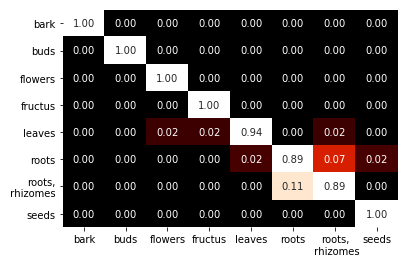

In [4]:
results_dirname = '../results/'
model_filename_base = 'parts_model_md_snn_'
results_filename = 'rank='+str(rank)+model_filename_base+'+CCA.npz'
df = np.load(results_dirname+results_filename)
accuracies = df['accuracies']
f1s = df['f1s']
cms = df['confusion_matrices']


medAcc = np.median(accuracies, axis=0)
medF1 = np.median(f1s, axis=0)
medCMs = np.median(cms, axis=0)

print 'Median accuracy: train=%.4f test=%.4f test2=%.4f' % (medAcc[0], medAcc[1], medAcc[2])
print 'Median F1: train=%.4f test=%.4f test2=%.4f' % (medF1[0], medF1[1], medF1[2])
clsnms = ['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots', 'roots,\n rhizomes', 'seeds']
df = pd.DataFrame(medCMs, columns=clsnms)
df['names'] = clsnms
df = df.set_index('names')
medCMs /= np.sum(medCMs, axis=1, keepdims=True)
msk1 = medCMs.copy()
np.fill_diagonal(msk1, 0.)
sns.heatmap(
    medCMs, annot=True, vmin=msk1.min(), vmax=1.05*msk1.max(),
    xticklabels=clsnms, yticklabels=clsnms, cbar=None,
    fmt='.2f', cmap='gist_heat', #mask=np.eye(len(clsnms))
)
plt.savefig('parts_snmf.pdf')

Median accuracy: train=0.9640 test=0.8720 test2=0.8409
Median F1: train=0.9649 test=0.8741 test2=0.8445


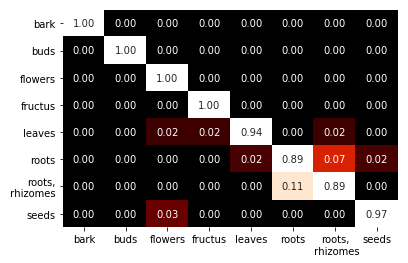